In [1]:
import os
import json

from utils import *


with open("./images/tasks.json", "r") as task_imglist_file:
    TASK_IMGLIST = json.load(task_imglist_file)
    
IMAGES = {}
for task in TASK_IMGLIST:
    for img_name in TASK_IMGLIST[task]:
        IMAGES[img_name] = cv.imread('./images/' + img_name, cv.IMREAD_GRAYSCALE)

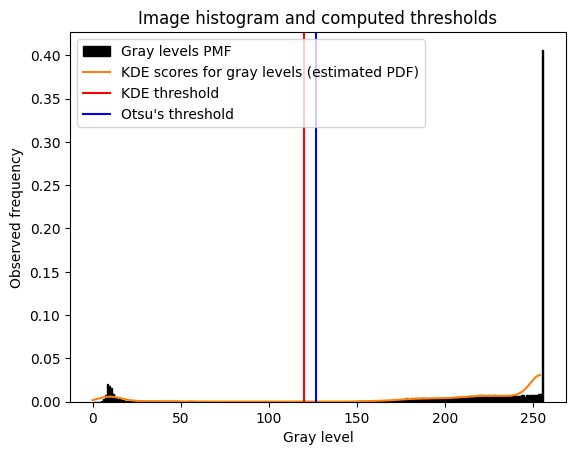

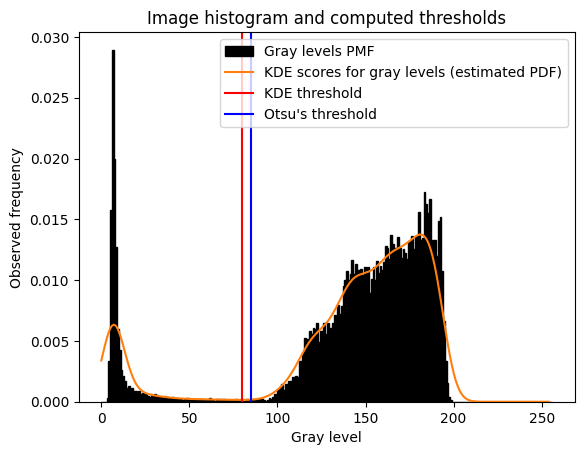

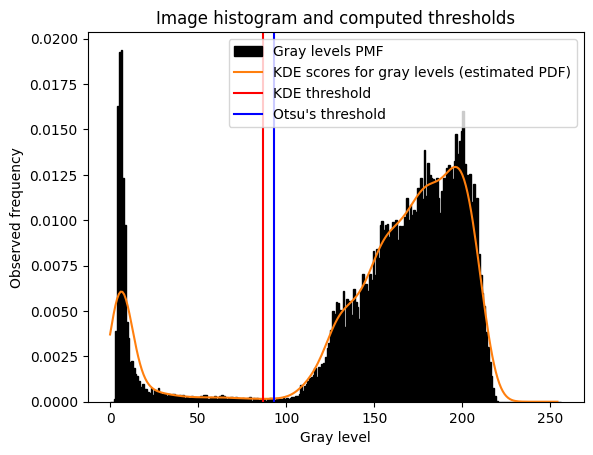

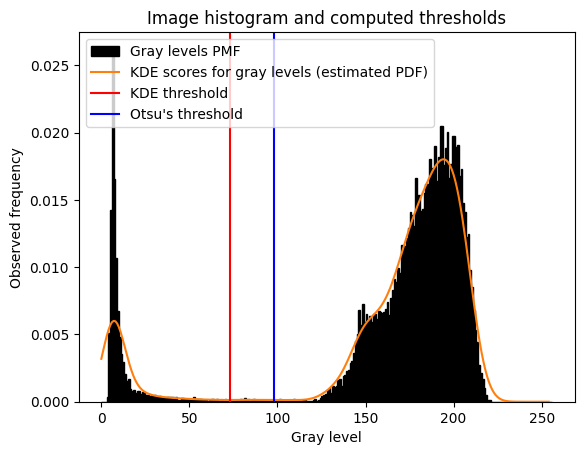

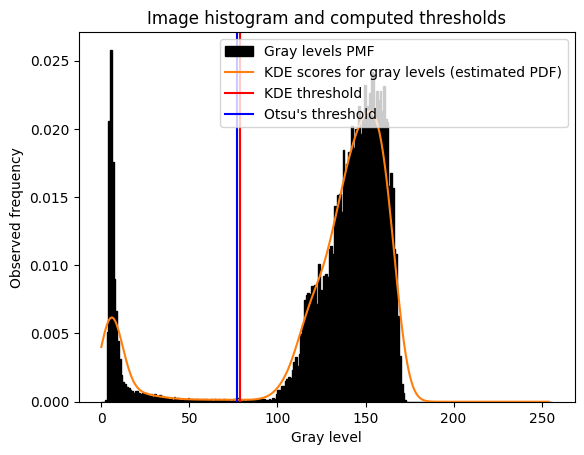

In [2]:
for img_name in TASK_IMGLIST['TASK_1']:
    X = np.arange(255)[:, None]
    kde = KernelDensity(kernel='gaussian', bandwidth=6).fit(IMAGES[img_name].ravel()[:, None])
    log_dens = kde.score_samples(X)
    threshold = scipy.signal.argrelmin(log_dens)[0][0]
    otsu_threshold, _ = cv.threshold(IMAGES[img_name], 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
    plt.hist(IMAGES[img_name].ravel(), bins=256, range=(0, 256), density=True, fc='k', ec='k', label='Gray levels PMF') #calculating histogram
    plt.plot(np.exp(log_dens), label='KDE scores for gray levels (estimated PDF)')
    plt.axvline(x=threshold, color='red', label='KDE threshold')
    plt.axvline(x=otsu_threshold, color='blue', label='Otsu\'s threshold')
    plt.xlabel('Gray level')
    plt.ylabel('Observed frequency')
    plt.title('Image histogram and computed thresholds')
    plt.legend()
    plt.show()

## TASKS ##

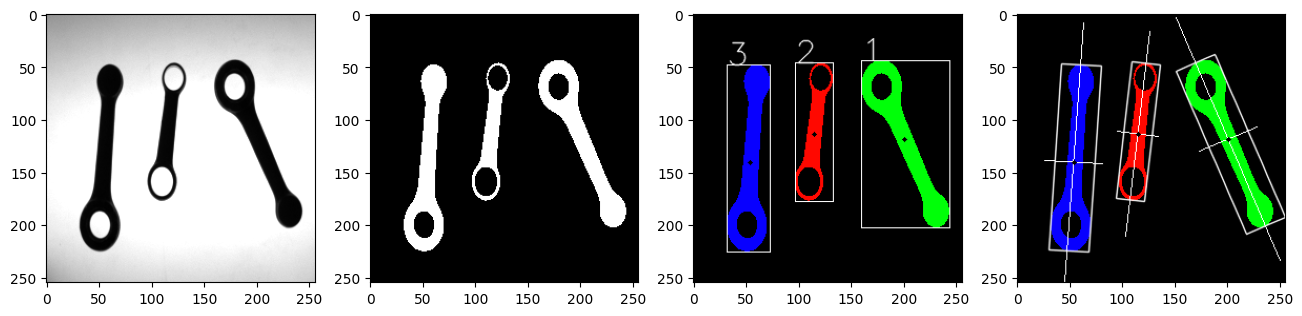

The rod labeled 1 is of type A
Its barycenter is at position (119, 201), it has an orientation angle of 113.21 degrees, its length is 168.86, its width is 40.31, and its width at the barycenter is 15.23
The only hole in the rod is at position (179, 69) and has diameter equal to 23.15


The rod labeled 2 is of type B
Its barycenter is at position (114, 115), it has an orientation angle of 83.40 degrees, its length is 130.86, its width is 27.17, and its width at the barycenter is 14.04
The first hole in the rod is at position (110, 159) and has diameter equal to 25.23
The second hole in the rod is at position (121, 60) and has diameter equal to 21.88


The rod labeled 3 is of type A
Its barycenter is at position (141, 55), it has an orientation angle of 85.97 degrees, its length is 177.41, its width is 38.05, and its width at the barycenter is 14.04
The only hole in the rod is at position (51, 200) and has diameter equal to 23.12







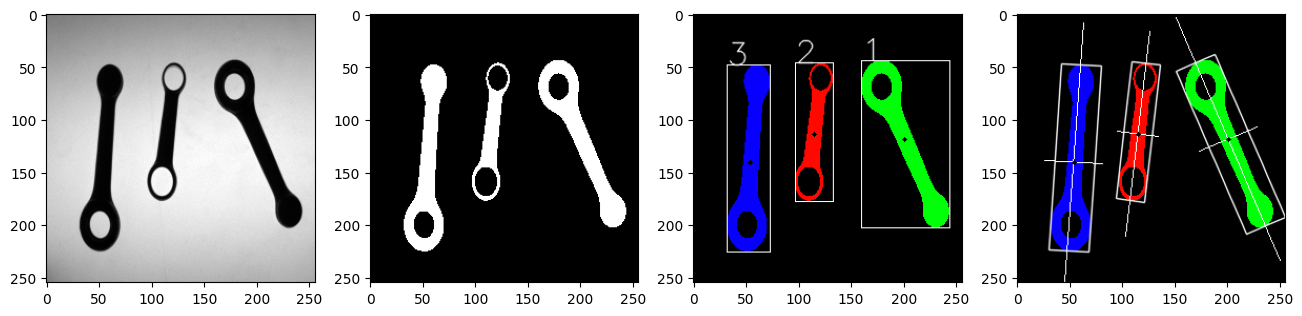

The rod labeled 1 is of type A
Its barycenter is at position (119, 201), it has an orientation angle of 113.20 degrees, its length is 168.86, its width is 40.31, and its width at the barycenter is 15.23
The only hole in the rod is at position (179, 69) and has diameter equal to 23.12


The rod labeled 2 is of type B
Its barycenter is at position (114, 115), it has an orientation angle of 83.50 degrees, its length is 131.86, its width is 27.29, and its width at the barycenter is 14.04
The first hole in the rod is at position (110, 159) and has diameter equal to 25.18
The second hole in the rod is at position (121, 60) and has diameter equal to 21.85


The rod labeled 3 is of type A
Its barycenter is at position (141, 55), it has an orientation angle of 85.99 degrees, its length is 177.41, its width is 38.05, and its width at the barycenter is 14.04
The only hole in the rod is at position (51, 200) and has diameter equal to 23.12







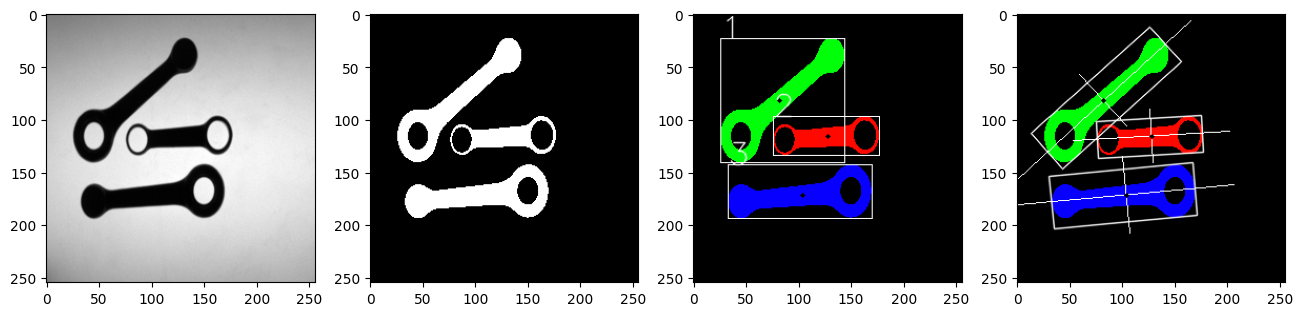

The rod labeled 1 is of type A
Its barycenter is at position (82, 82), it has an orientation angle of 222.02 degrees, its length is 151.56, its width is 44.60, and its width at the barycenter is 16.97
The only hole in the rod is at position (45, 116) and has diameter equal to 23.21


The rod labeled 2 is of type B
Its barycenter is at position (117, 129), it has an orientation angle of 183.43 degrees, its length is 100.18, its width is 35.06, and its width at the barycenter is 17.03
The first hole in the rod is at position (87, 119) and has diameter equal to 22.14
The second hole in the rod is at position (163, 115) and has diameter equal to 25.12


The rod labeled 3 is of type A
Its barycenter is at position (172, 105), it has an orientation angle of 185.36 degrees, its length is 137.62, its width is 50.16, and its width at the barycenter is 19.10
The only hole in the rod is at position (150, 168) and has diameter equal to 23.68







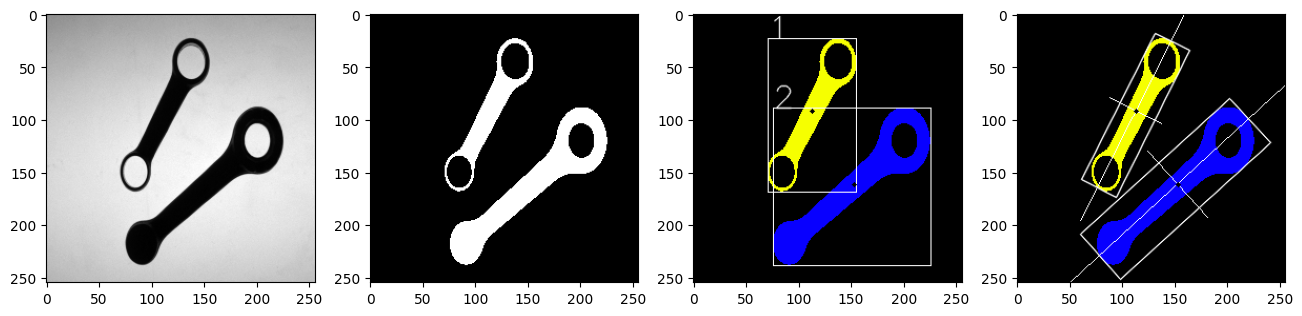

The rod labeled 1 is of type B
Its barycenter is at position (92, 114), it has an orientation angle of 63.54 degrees, its length is 156.52, its width is 37.12, and its width at the barycenter is 17.89
The first hole in the rod is at position (84, 150) and has diameter equal to 27.87
The second hole in the rod is at position (138, 44) and has diameter equal to 31.23


The rod labeled 2 is of type A
Its barycenter is at position (162, 153), it has an orientation angle of 222.18 degrees, its length is 191.85, its width is 57.31, and its width at the barycenter is 21.93
The only hole in the rod is at position (201, 120) and has diameter equal to 29.39







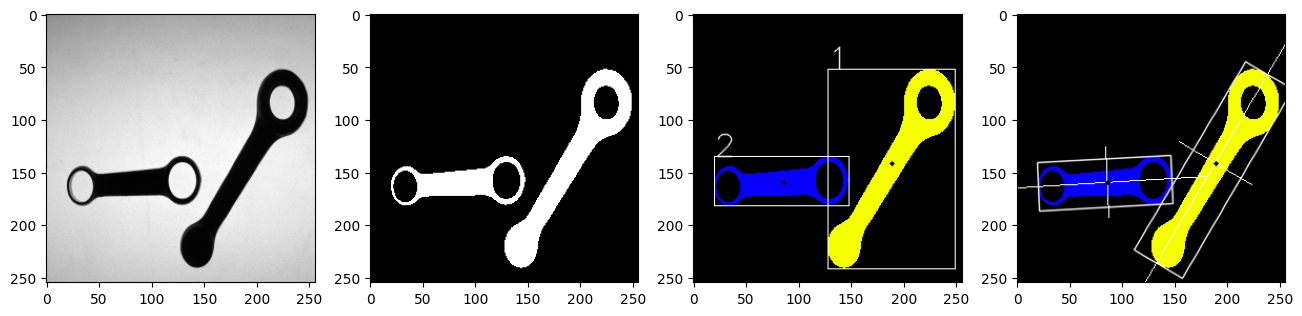

The rod labeled 1 is of type A
Its barycenter is at position (143, 189), it has an orientation angle of 59.57 degrees, its length is 208.39, its width is 53.34, and its width at the barycenter is 19.72
The only hole in the rod is at position (224, 84) and has diameter equal to 28.58


The rod labeled 2 is of type B
Its barycenter is at position (160, 86), it has an orientation angle of 183.12 degrees, its length is 127.19, its width is 46.04, and its width at the barycenter is 23.02
The first hole in the rod is at position (33, 164) and has diameter equal to 27.03
The second hole in the rod is at position (129, 158) and has diameter equal to 31.41







In [3]:
for img_name in TASK_IMGLIST['TASK_1']:
    rods_descriptions = processImage(IMAGES[img_name], False)

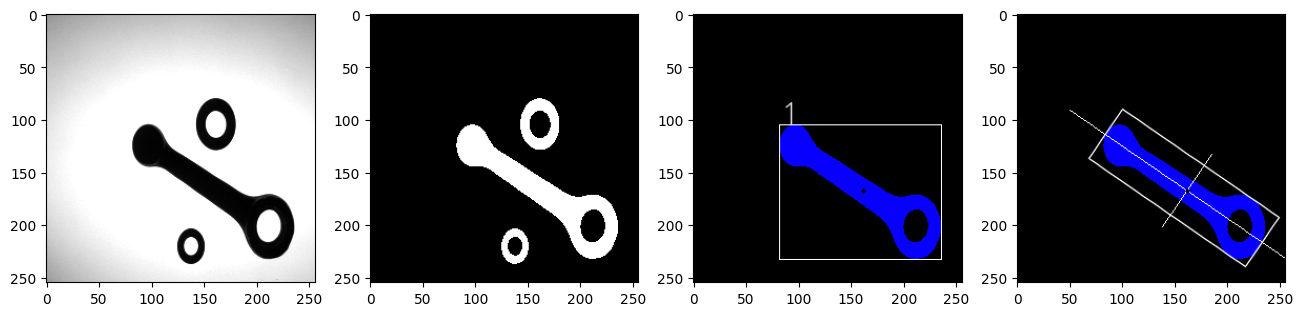

The rod labeled 1 is of type A
Its barycenter is at position (168, 162), it has an orientation angle of 145.42 degrees, its length is 181.14, its width is 56.86, and its width at the barycenter is 21.63
The only hole in the rod is at position (212, 201) and has diameter equal to 27.98







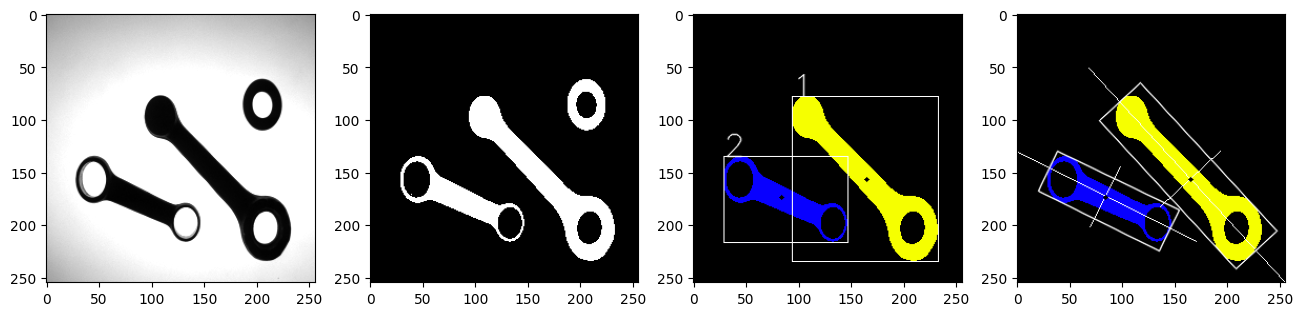

The rod labeled 1 is of type A
Its barycenter is at position (158, 166), it has an orientation angle of 132.68 degrees, its length is 191.78, its width is 53.08, and its width at the barycenter is 21.21
The only hole in the rod is at position (208, 203) and has diameter equal to 27.98


The rod labeled 2 is of type B
Its barycenter is at position (175, 84), it has an orientation angle of 153.92 degrees, its length is 128.81, its width is 43.38, and its width at the barycenter is 21.02
The first hole in the rod is at position (133, 198) and has diameter equal to 27.16
The second hole in the rod is at position (44, 157) and has diameter equal to 30.55







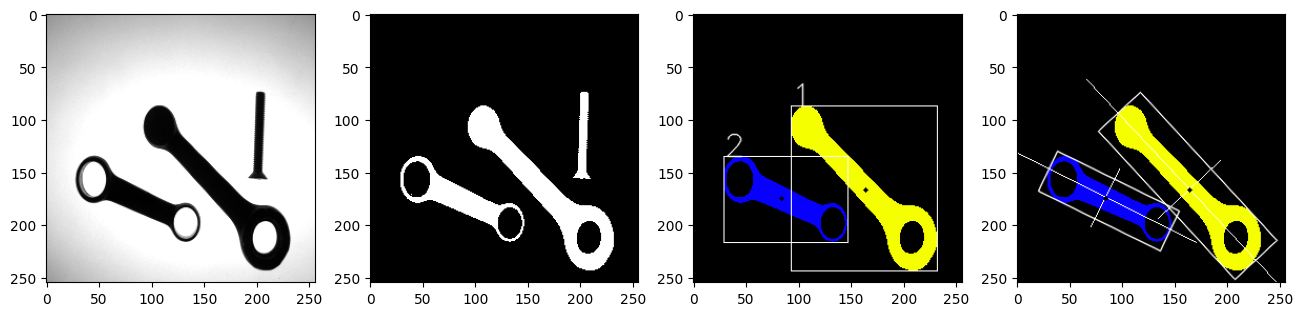

The rod labeled 1 is of type A
Its barycenter is at position (167, 165), it has an orientation angle of 132.82 degrees, its length is 191.78, its width is 54.49, and its width at the barycenter is 20.52
The only hole in the rod is at position (208, 212) and has diameter equal to 27.85


The rod labeled 2 is of type B
Its barycenter is at position (175, 85), it has an orientation angle of 153.93 degrees, its length is 129.25, its width is 42.05, and its width at the barycenter is 21.02
The first hole in the rod is at position (133, 198) and has diameter equal to 27.14
The second hole in the rod is at position (44, 157) and has diameter equal to 30.51







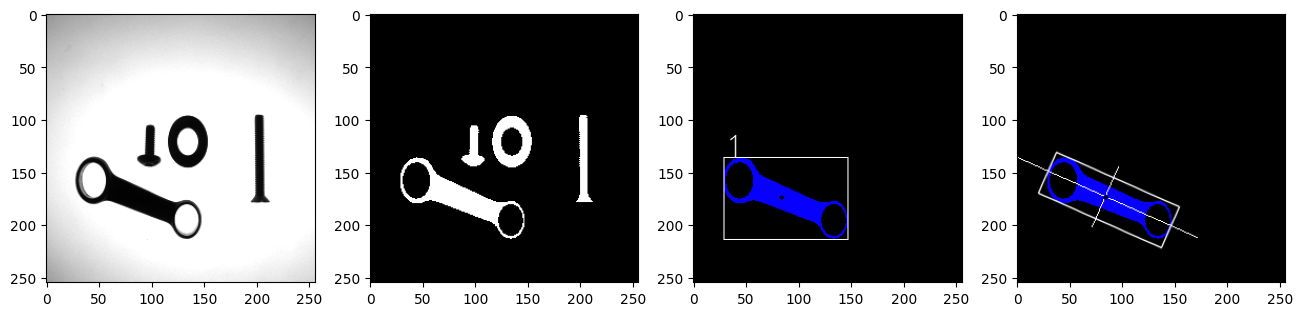

The rod labeled 1 is of type B
Its barycenter is at position (174, 85), it has an orientation angle of 156.06 degrees, its length is 128.04, its width is 42.54, and its width at the barycenter is 21.02
The first hole in the rod is at position (133, 196) and has diameter equal to 27.59
The second hole in the rod is at position (44, 158) and has diameter equal to 30.87







In [4]:
for img_name in TASK_IMGLIST['TASK_2_1']:
    rods_descriptions = processImage(IMAGES[img_name], False)

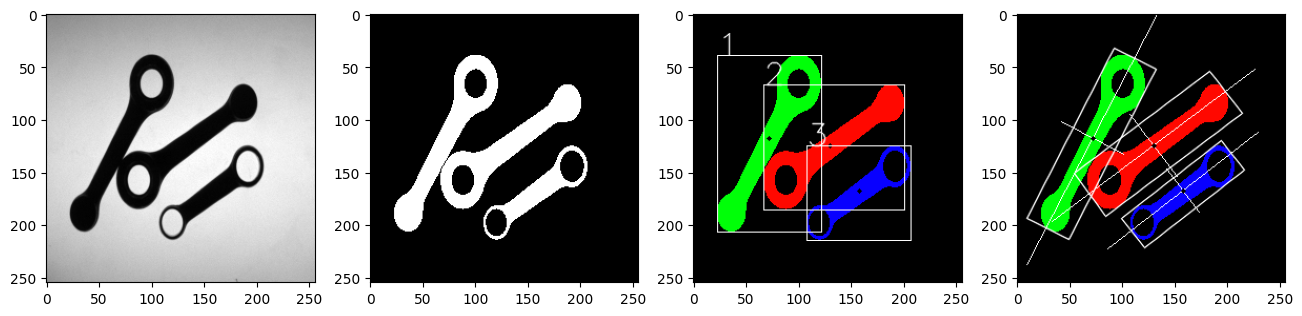

The rod labeled 1 is of type A
Its barycenter is at position (119, 73), it has an orientation angle of 62.80 degrees, its length is 182.02, its width is 44.72, and its width at the barycenter is 16.55
The only hole in the rod is at position (100, 66) and has diameter equal to 25.08


The rod labeled 2 is of type A
Its barycenter is at position (126, 131), it has an orientation angle of 216.91 degrees, its length is 161.40, its width is 50.61, and its width at the barycenter is 19.42
The only hole in the rod is at position (88, 157) and has diameter equal to 25.53


The rod labeled 3 is of type B
Its barycenter is at position (169, 159), it has an orientation angle of 217.79 degrees, its length is 120.42, its width is 35.61, and its width at the barycenter is 17.80
The first hole in the rod is at position (120, 198) and has diameter equal to 23.64
The second hole in the rod is at position (192, 144) and has diameter equal to 26.93







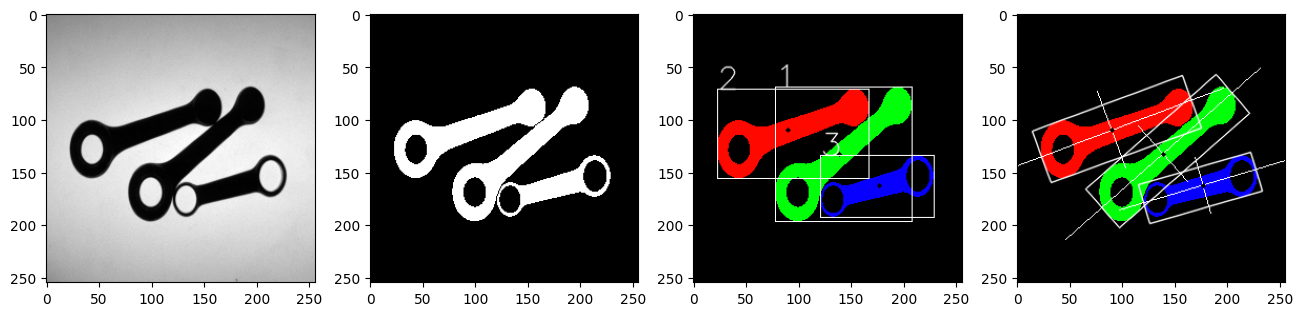

The rod labeled 1 is of type A
Its barycenter is at position (134, 140), it has an orientation angle of 221.50 degrees, its length is 165.10, its width is 48.92, and its width at the barycenter is 19.21
The only hole in the rod is at position (99, 169) and has diameter equal to 25.42


The rod labeled 2 is of type A
Its barycenter is at position (111, 91), it has an orientation angle of 200.21 degrees, its length is 152.51, its width is 53.14, and its width at the barycenter is 20.25
The only hole in the rod is at position (43, 128) and has diameter equal to 24.96


The rod labeled 3 is of type B
Its barycenter is at position (164, 177), it has an orientation angle of 196.52 degrees, its length is 111.40, its width is 38.60, and its width at the barycenter is 18.97
The first hole in the rod is at position (133, 176) and has diameter equal to 23.83
The second hole in the rod is at position (214, 154) and has diameter equal to 26.58







In [5]:
for img_name in TASK_IMGLIST['TASK_2_2']:
    rods_descriptions = processImage(IMAGES[img_name], False)

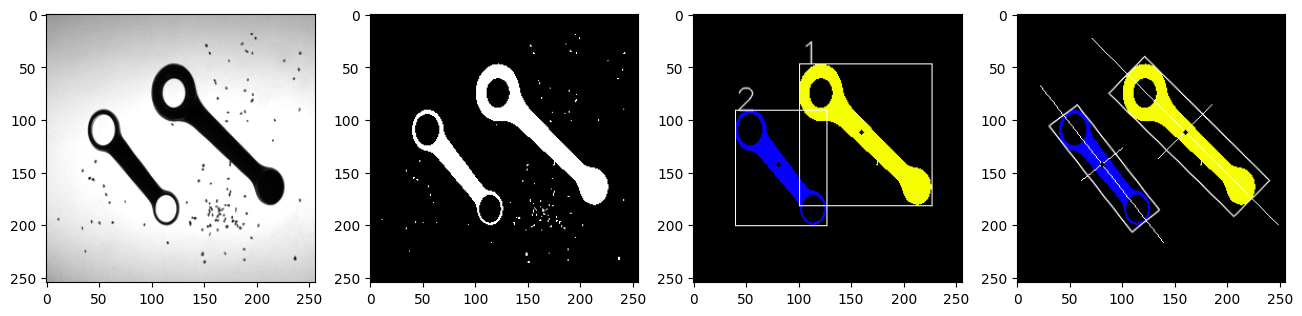

The rod labeled 1 is of type A
Its barycenter is at position (113, 161), it has an orientation angle of 135.01 degrees, its length is 167.59, its width is 48.08, and its width at the barycenter is 18.38
The only hole in the rod is at position (121, 75) and has diameter equal to 25.67


The rod labeled 2 is of type B
Its barycenter is at position (143, 81), it has an orientation angle of 127.98 degrees, its length is 126.82, its width is 33.42, and its width at the barycenter is 16.28
The first hole in the rod is at position (114, 185) and has diameter equal to 24.24
The second hole in the rod is at position (54, 110) and has diameter equal to 27.17







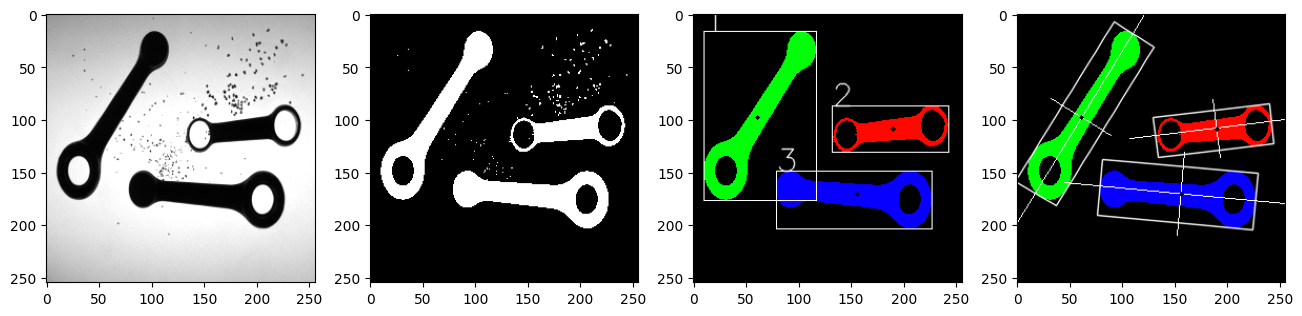

The rod labeled 1 is of type A
Its barycenter is at position (99, 62), it has an orientation angle of 58.28 degrees, its length is 177.34, its width is 45.28, and its width at the barycenter is 16.64
The only hole in the rod is at position (31, 149) and has diameter equal to 25.17


The rod labeled 2 is of type B
Its barycenter is at position (110, 190), it has an orientation angle of 186.81 degrees, its length is 111.76, its width is 38.21, and its width at the barycenter is 19.10
The first hole in the rod is at position (146, 114) and has diameter equal to 23.88
The second hole in the rod is at position (228, 106) and has diameter equal to 26.43


The rod labeled 3 is of type A
Its barycenter is at position (172, 157), it has an orientation angle of 174.81 degrees, its length is 148.57, its width is 54.23, and its width at the barycenter is 20.02
The only hole in the rod is at position (206, 176) and has diameter equal to 25.10







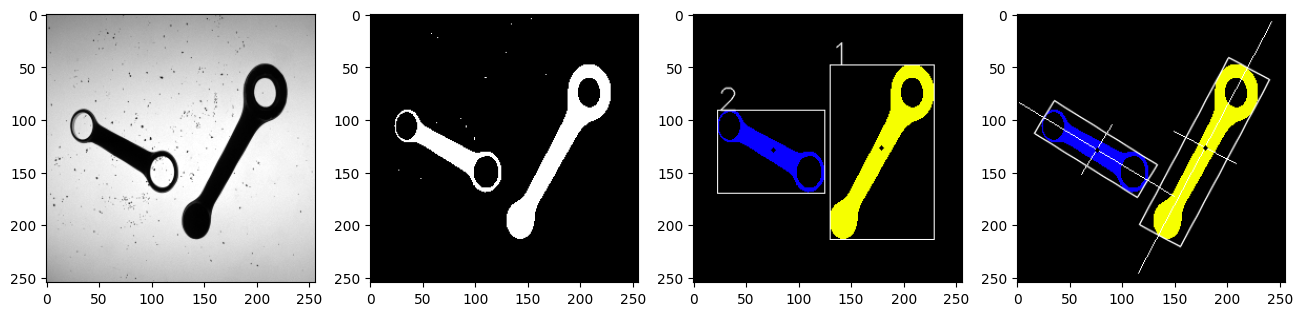

The rod labeled 1 is of type A
Its barycenter is at position (127, 180), it has an orientation angle of 61.95 degrees, its length is 180.29, its width is 44.29, and its width at the barycenter is 16.12
The only hole in the rod is at position (208, 74) and has diameter equal to 25.34


The rod labeled 2 is of type B
Its barycenter is at position (130, 76), it has an orientation angle of 148.49 degrees, its length is 115.43, its width is 36.36, and its width at the barycenter is 18.36
The first hole in the rod is at position (110, 150) and has diameter equal to 27.60
The second hole in the rod is at position (34, 106) and has diameter equal to 24.00







In [6]:
for img_name in TASK_IMGLIST['TASK_2_3']:
    rods_descriptions = processImage(IMAGES[img_name], False)